In [1]:
import os
import sys

module_path = os.path.join(os.getcwd(), '..', 'module')
sys.path.append(module_path)

from Data_preparation import data_for_clust
from Data_preparation import quantity_executors
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

In [3]:
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering

In [4]:
not_changed_df = pd.read_excel('../../data/Здания_Финальная_версия_ред.xlsx', 'Финальная ред')

In [5]:
not_changed_df['ИНН исполнителя'] = not_changed_df['ИНН исполнителя'].apply(
        lambda x: f"{int(x):.0f}" if pd.notna(x) else ''
    )

In [6]:
not_changed_df.head()

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),ОКВЭД
0,2780515018525000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722002e+17,2025-06-09,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей
1,2780514542825000014,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей
2,2780514943025000017,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,329751.93,329751.93,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей
3,2780514920725000015,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей
4,2780514540325000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-05-31,2025-12-31,155338.94,155338.94,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей


In [7]:
first_df = data_for_clust('../../data/Здания_Финальная_версия_ред.xlsx', 'Финальная ред')


first_df = first_df.drop(0).reset_index(drop=True)


clust_data = first_df[['ИНН исполнителя', 'Средняя цена контракта', 'Количество контрактов']]


clust_data = clust_data.copy()

clust_data['Средняя цена контракта log'] = np.log1p(clust_data['Средняя цена контракта'])
clust_data['Количество контрактов log'] = np.log1p(clust_data['Количество контрактов'])

clust_data_new = clust_data.drop(['Средняя цена контракта', 'ИНН исполнителя', 'Количество контрактов'], axis=1)

In [8]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001146420,200000.00,200000.000,200000.00,199990.25,199990.250,1,3732000.0,3277000.0,455000.0,1,0,0
1,1001333318,280192.52,280192.520,280192.52,246645.01,246645.010,1,61659000.0,24491000.0,37168000.0,1,0,0
2,102002711630,786656.66,786656.660,786656.66,786656.66,786656.660,1,NaN,NaN,0.0,0,0,0
3,141701766795,204449.00,102224.500,140000.00,74767.36,37383.680,2,NaN,NaN,0.0,2,0,1
4,2100009963,554000.00,277000.000,438000.00,554000.00,277000.000,2,1756000.0,729000.0,1027000.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,7843302537,14000.00,14000.000,14000.00,14000.00,14000.000,1,NaN,NaN,0.0,0,0,0
384,7843307888,331626.57,331626.570,331626.57,331626.57,331626.570,1,NaN,NaN,0.0,0,0,0
385,8610006030,2017459.58,403491.916,475204.20,2017459.58,403491.916,5,22056000.0,14090000.0,7966000.0,0,2,0
386,8610031653,1543683.74,1543683.740,1543683.74,1543683.74,1543683.740,1,1870000.0,1117000.0,753000.0,0,0,0


In [9]:
column_names = clust_data_new.columns
index_names = clust_data_new.index

scaler = MinMaxScaler()
clust_data_scaled = scaler.fit_transform(clust_data_new)

clust_data_scaled = pd.DataFrame(clust_data_scaled, 
                                columns=column_names,
                                index=index_names)


print(clust_data_scaled.head())

   Средняя цена контракта log  Количество контрактов log
0                    0.360826                   0.000000
1                    0.393099                   0.000000
2                    0.491914                   0.000000
3                    0.296583                   0.100287
4                    0.392002                   0.100287


In [10]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
0,0.360826,0.000000
1,0.393099,0.000000
2,0.491914,0.000000
3,0.296583,0.100287
4,0.392002,0.100287


In [11]:
clust_data_scaled.describe()

,Средняя цена контракта log,Количество контрактов log
count,388.000000,388.000000
mean,0.441862,0.069337
std,0.200048,0.136774
min,0.000000,0.000000
25%,0.306039,0.000000
50%,0.417068,0.000000
75%,0.574420,0.100287
max,1.000000,1.000000


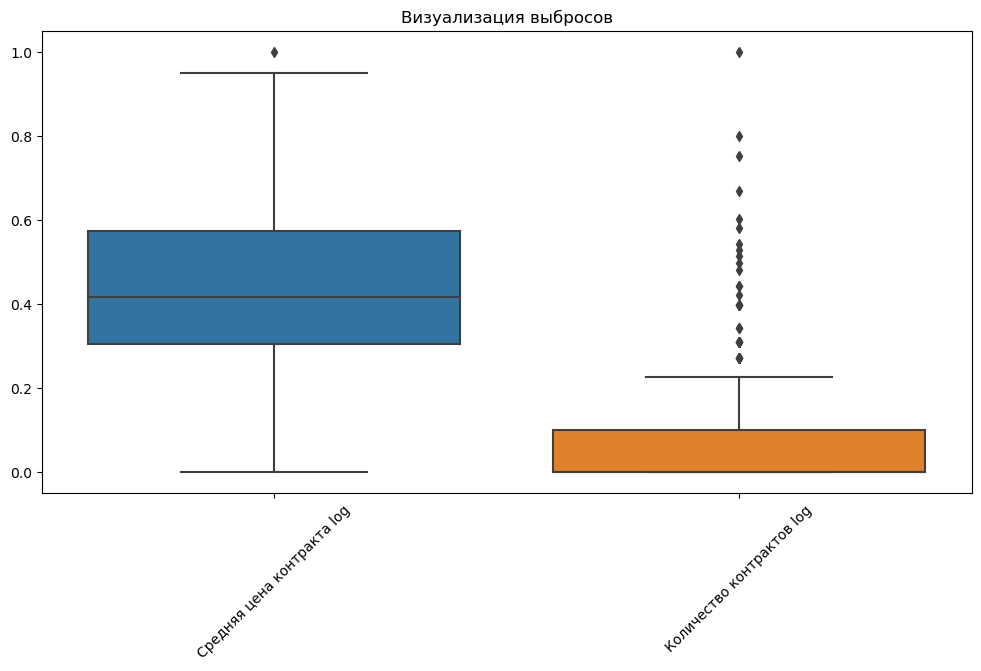

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=clust_data_scaled)
plt.xticks(rotation=45)
plt.title('Визуализация выбросов')
plt.show()

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

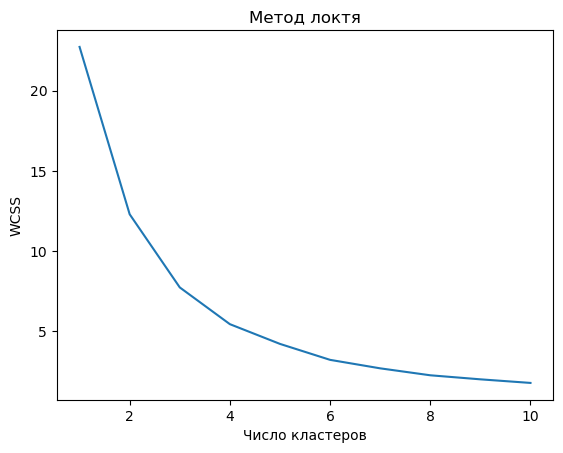

In [13]:
X = clust_data_scaled
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

In [14]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [15]:
clust_data_scaled.columns.tolist()

['Средняя цена контракта log', 'Количество контрактов log']

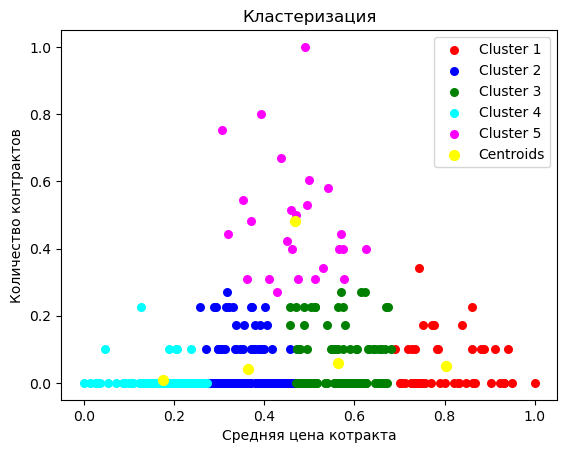

Центроиды кластеров:
   Средняя цена контракта log  Количество контрактов log  Кластер
0                    0.803768                   0.050180        0
1                    0.364621                   0.040451        1
2                    0.564043                   0.059757        2
3                    0.175711                   0.009708        3
4                    0.466966                   0.481620        4


In [16]:
X_array = X.values

plt.scatter(X_array[y_kmeans == 0, 0], X_array[y_kmeans == 0, 1], s=30, c='red', label='Cluster 1')
plt.scatter(X_array[y_kmeans == 1, 0], X_array[y_kmeans == 1, 1], s=30, c='blue', label='Cluster 2')
plt.scatter(X_array[y_kmeans == 2, 0], X_array[y_kmeans == 2, 1], s=30, c='green', label='Cluster 3')
plt.scatter(X_array[y_kmeans == 3, 0], X_array[y_kmeans == 3, 1], s=30, c='cyan', label='Cluster 4')
plt.scatter(X_array[y_kmeans == 4, 0], X_array[y_kmeans == 4, 1], s=30, c='magenta', label='Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='yellow', label='Centroids')
plt.title('Кластеризация')
plt.xlabel('Средняя цена котракта')
plt.ylabel('Количество контрактов')
plt.legend()
plt.show()

centroids = kmeans.cluster_centers_

centroids_df = pd.DataFrame(centroids, columns=clust_data_scaled.columns.tolist())
centroids_df['Кластер'] = range(len(centroids))

print("Центроиды кластеров:")
print(centroids_df)

In [17]:
clustered_data = X.copy()
clustered_data['Cluster'] = y_kmeans
clustered_data.head()

,Средняя цена контракта log,Количество контрактов log,Cluster
0,0.360826,0.000000,1
1,0.393099,0.000000,1
2,0.491914,0.000000,2
3,0.296583,0.100287,1
4,0.392002,0.100287,1


In [18]:
clustered_data = pd.concat([clust_data['ИНН исполнителя'].reset_index(drop=True), clustered_data.reset_index(drop=True)], axis=1)

In [19]:
clustered_data.head()

,ИНН исполнителя,Средняя цена контракта log,Количество контрактов log,Cluster
0,1001146420,0.360826,0.000000,1
1,1001333318,0.393099,0.000000,1
2,102002711630,0.491914,0.000000,2
3,141701766795,0.296583,0.100287,1
4,2100009963,0.392002,0.100287,1


In [20]:
data_with_clust = clust_data.copy()
data_with_clust['Cluster'] = y_kmeans
data_with_clust = data_with_clust.drop(['Средняя цена контракта log', 'Количество контрактов log'], axis = 1).round(2)
data_with_clust.head()

,ИНН исполнителя,Средняя цена контракта,Количество контрактов,Cluster
0,1001146420,200000.00,1,1
1,1001333318,280192.52,1,1
2,102002711630,786656.66,1,2
3,141701766795,102224.50,2,1
4,2100009963,277000.00,2,1


In [21]:
result = data_with_clust.groupby('Cluster').agg({
    'Средняя цена контракта': 'mean',
    'Количество контрактов': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'count'}).round(2)
result.head()

,Средняя цена контракта,Количество контрактов,count
Cluster,,,
0,30053536.71,1.60,47
1,240195.74,1.48,136
2,2075418.14,1.71,105
3,35837.09,1.11,75
4,862361.59,18.40,25


In [22]:
dbscan = DBSCAN(eps=0.09, min_samples=2)
clusters = dbscan.fit_predict(clust_data_scaled)

In [23]:
clusters

array([ 0,  0,  0,  1,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,
        1, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,
        0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
        0,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,
        1,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  1,  1,
        1,  0,  1,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  1,  1,  0,  0,
        1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1, -1,
        0,  1, -1,  1,  1,  1,  1, -1,  1,  1,  0,  0,  0,  1,  0,  0,  1,
        0,  0,  0, -1,  0,  1,  0,  0,  0,  1,  1,  2,  0,  0,  0,  1,  0,
        0,  1,  0,  1,  0

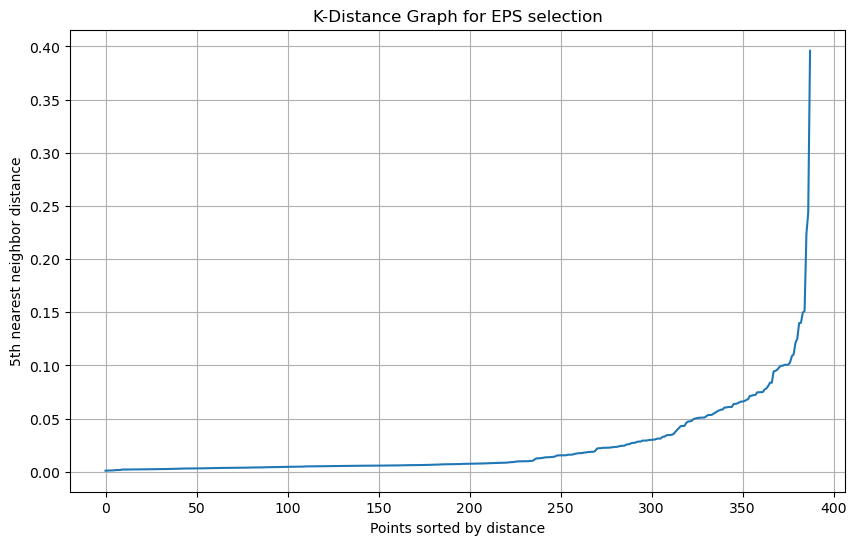

In [24]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(clust_data_scaled)
distances, indices = neighbors_fit.kneighbors(clust_data_scaled)

distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('K-Distance Graph for EPS selection')
plt.grid(True)

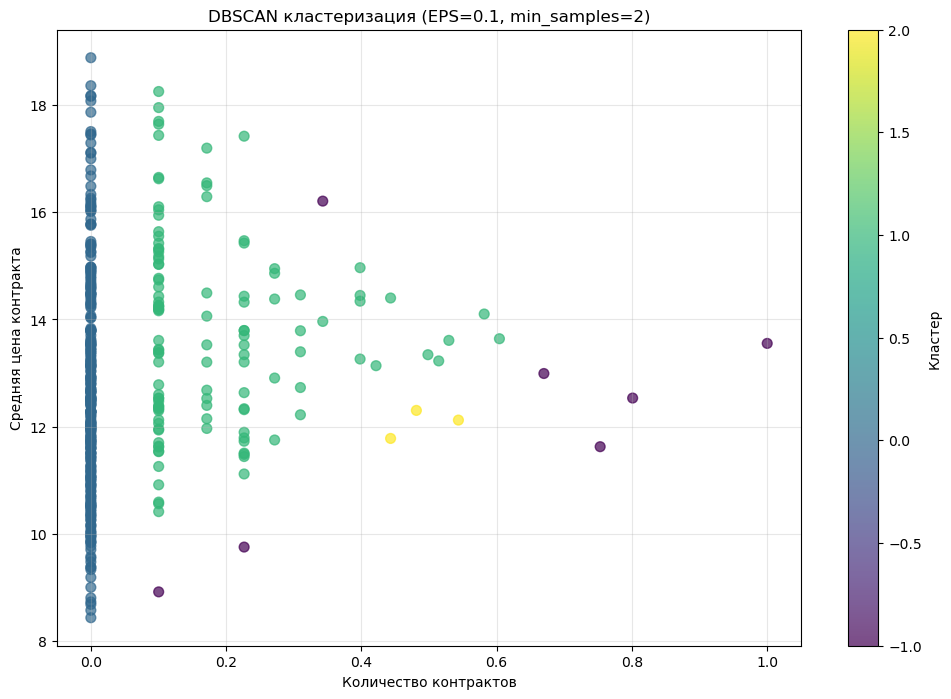

In [25]:

plt.figure(figsize=(12, 8))
scatter = plt.scatter(clust_data_scaled['Количество контрактов log'], clust_data['Средняя цена контракта log'], 
                     c=clusters, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('Количество контрактов')
plt.ylabel('Средняя цена контракта')
plt.title('DBSCAN кластеризация (EPS=0.1, min_samples=2)')
plt.grid(True, alpha=0.3)

In [26]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
0,0.360826,0.000000
1,0.393099,0.000000
2,0.491914,0.000000
3,0.296583,0.100287
4,0.392002,0.100287


In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

hierarchical = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward'
)

data = hierarchical.fit_predict(clust_data_scaled)

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [28]:
data

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1,
       2, 0, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2,
       1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 2, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 0,
       2, 0, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 1,
       0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 1,
       0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1,

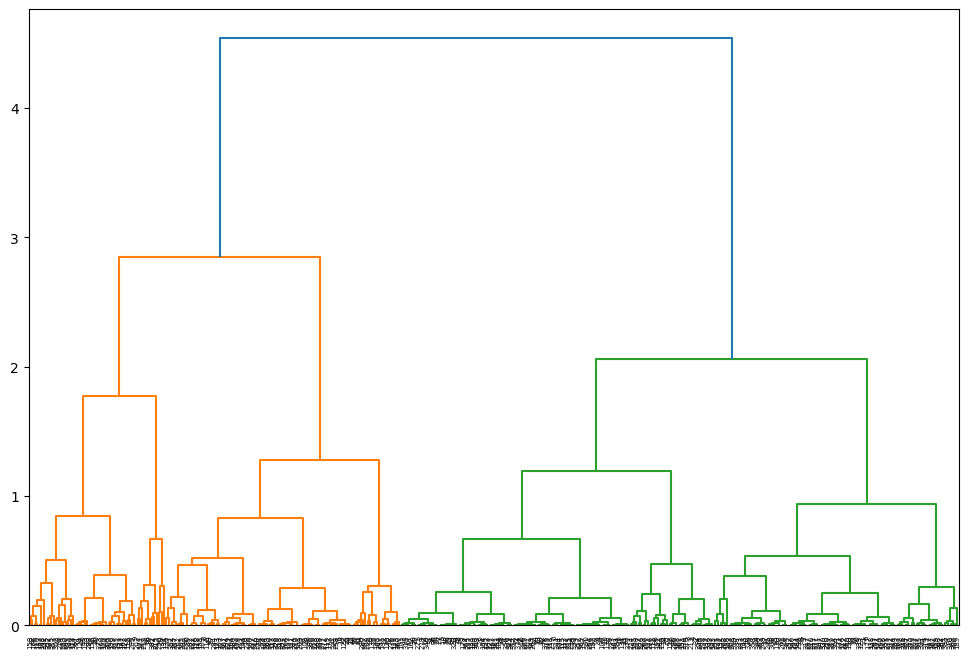

In [29]:
linked = linkage(clust_data_scaled, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='level',
           )
plt.show()

In [30]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
0,0.360826,0.000000
1,0.393099,0.000000
2,0.491914,0.000000
3,0.296583,0.100287
4,0.392002,0.100287


In [31]:
clust_data_scaled.to_excel('Здания для кластеризации.xlsx', index=False)

In [32]:
clust_data_ex = clust_data.copy()
clust_data_ex = clust_data_ex.drop(['Средняя цена контракта log', 'Количество контрактов log'], axis = 1)
clust_data_ex.head()

,ИНН исполнителя,Средняя цена контракта,Количество контрактов
0,1001146420,200000.00,1
1,1001333318,280192.52,1
2,102002711630,786656.66,1
3,141701766795,102224.50,2
4,2100009963,277000.00,2


In [33]:
clust_data_ex.to_excel('Здания для кластеризации 2.xlsx', index=False)

In [34]:
first_df[["ИНН исполнителя", "Средняя цена контракта", "Количество контрактов", "Прибыль(убыток)"]].to_excel('Здания для кластеризации 3.xlsx', index=False)

In [35]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001146420,200000.00,200000.000,200000.00,199990.25,199990.250,1,3732000.0,3277000.0,455000.0,1,0,0
1,1001333318,280192.52,280192.520,280192.52,246645.01,246645.010,1,61659000.0,24491000.0,37168000.0,1,0,0
2,102002711630,786656.66,786656.660,786656.66,786656.66,786656.660,1,NaN,NaN,0.0,0,0,0
3,141701766795,204449.00,102224.500,140000.00,74767.36,37383.680,2,NaN,NaN,0.0,2,0,1
4,2100009963,554000.00,277000.000,438000.00,554000.00,277000.000,2,1756000.0,729000.0,1027000.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,7843302537,14000.00,14000.000,14000.00,14000.00,14000.000,1,NaN,NaN,0.0,0,0,0
384,7843307888,331626.57,331626.570,331626.57,331626.57,331626.570,1,NaN,NaN,0.0,0,0,0
385,8610006030,2017459.58,403491.916,475204.20,2017459.58,403491.916,5,22056000.0,14090000.0,7966000.0,0,2,0
386,8610031653,1543683.74,1543683.740,1543683.74,1543683.74,1543683.740,1,1870000.0,1117000.0,753000.0,0,0,0


In [36]:
similarity_df = first_df.drop(["Сумма контрактов", "Сумма оплат"], axis = 1)

In [37]:
# similarity_df = similarity_df.drop(0).reset_index(drop=True)

In [38]:
similarity_df

,ИНН исполнителя,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001146420,200000.000,200000.00,199990.250,1,3732000.0,3277000.0,455000.0,1,0,0
1,1001333318,280192.520,280192.52,246645.010,1,61659000.0,24491000.0,37168000.0,1,0,0
2,102002711630,786656.660,786656.66,786656.660,1,NaN,NaN,0.0,0,0,0
3,141701766795,102224.500,140000.00,37383.680,2,NaN,NaN,0.0,2,0,1
4,2100009963,277000.000,438000.00,277000.000,2,1756000.0,729000.0,1027000.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
383,7843302537,14000.000,14000.00,14000.000,1,NaN,NaN,0.0,0,0,0
384,7843307888,331626.570,331626.57,331626.570,1,NaN,NaN,0.0,0,0,0
385,8610006030,403491.916,475204.20,403491.916,5,22056000.0,14090000.0,7966000.0,0,2,0
386,8610031653,1543683.740,1543683.74,1543683.740,1,1870000.0,1117000.0,753000.0,0,0,0


In [39]:
similarity_df.isna().sum().sum()

344

In [40]:
similarity = similarity_df.copy()

similarity['Рентабельность продаж'] = ((
    similarity['Прибыль(убыток)'] / similarity['Доходы']
    ).where(similarity['ИНН исполнителя'].astype(str).str.len() == 10))

similarity['Доля прекращенных контрактов'] = similarity['Количество прекращенных контрактов'] / similarity['Количество контрактов']
    
similarity['Доля штрафных контрактов'] = similarity['Неустойки (штрафы и пени)'] / similarity['Количество контрактов']
    
# similarity['Флаг цены'] = (
#     (similarity['Максимальная цена контракта'] > 250_000_000 * 0.2)
#     .astype(int)
# )

# similarity['Флаг контрактов'] = (
#     (similarity['Количество контрактов'] > 1)
#     .astype(int)
# )

# similarity['Флаг рентабельности'] = ((
#     similarity['Прибыль(убыток)'] / similarity['Доходы']
#     ).where(similarity['ИНН исполнителя'].astype(str).str.len() == 10) > 0.15).astype(int)
    

# similarity['Флаг прекращенных контрактов'] = (
#     (similarity['Количество прекращенных контрактов'] == 0)
#     .astype(int)
# )

# similarity['Флаг штрафов'] = (
#     (similarity['Неустойки (штрафы и пени)'] == 0)
#     .astype(int)
# )

# similarity['Флаг реестра'] = (
#     (similarity['Включение в реестр недобросовестных поставщиков'] == 0)
#     .astype(int)
# )

In [41]:
similarity.head()

,ИНН исполнителя,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов
0,1001146420,200000.00,200000.00,199990.25,1,3732000.0,3277000.0,455000.0,1,0,0,0.121919,1.0,0.0
1,1001333318,280192.52,280192.52,246645.01,1,61659000.0,24491000.0,37168000.0,1,0,0,0.602799,1.0,0.0
2,102002711630,786656.66,786656.66,786656.66,1,NaN,NaN,0.0,0,0,0,NaN,0.0,0.0
3,141701766795,102224.50,140000.00,37383.68,2,NaN,NaN,0.0,2,0,1,NaN,1.0,0.0
4,2100009963,277000.00,438000.00,277000.00,2,1756000.0,729000.0,1027000.0,0,0,0,0.584852,0.0,0.0


In [42]:
similarity = similarity.drop([
                             "Доходы", "Расходы", "Прибыль(убыток)",
                             "Включение в реестр недобросовестных поставщиков"], axis = 1)

In [43]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001146420,200000.00,200000.000,200000.00,199990.25,199990.250,1,3732000.0,3277000.0,455000.0,1,0,0
1,1001333318,280192.52,280192.520,280192.52,246645.01,246645.010,1,61659000.0,24491000.0,37168000.0,1,0,0
2,102002711630,786656.66,786656.660,786656.66,786656.66,786656.660,1,NaN,NaN,0.0,0,0,0
3,141701766795,204449.00,102224.500,140000.00,74767.36,37383.680,2,NaN,NaN,0.0,2,0,1
4,2100009963,554000.00,277000.000,438000.00,554000.00,277000.000,2,1756000.0,729000.0,1027000.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,7843302537,14000.00,14000.000,14000.00,14000.00,14000.000,1,NaN,NaN,0.0,0,0,0
384,7843307888,331626.57,331626.570,331626.57,331626.57,331626.570,1,NaN,NaN,0.0,0,0,0
385,8610006030,2017459.58,403491.916,475204.20,2017459.58,403491.916,5,22056000.0,14090000.0,7966000.0,0,2,0
386,8610031653,1543683.74,1543683.740,1543683.74,1543683.74,1543683.740,1,1870000.0,1117000.0,753000.0,0,0,0


In [44]:
full_df = pd.merge(not_changed_df, similarity, on="ИНН исполнителя", how="left")

In [45]:
full_df

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),ОКВЭД,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов
0,2780515018525000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722002e+17,2025-06-09,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439
1,2780514542825000014,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439
2,2780514943025000017,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,329751.93,329751.93,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439
3,2780514920725000015,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439
4,2780514540325000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-05-31,2025-12-31,155338.94,155338.94,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2782700967624000195,650803058133,НАМ ИГОРЬ САНУНОВИЧ Индивидуальный предпринима...,Исполнение завершено,3.722000e+17,2024-09-27,2024-12-31,396100.00,396100.00,NaN,NaN,Нет,нет,NaN,NaN,0.0,Деятельность консультативная в области компьют...,3.961000e+05,396100.00,3.961000e+05,1.0,0.0,0.0,NaN,0.00000,0.00000
996,1782541336124000003,7806272267,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АНГЕ...",Исполнение завершено,1.721000e+17,2024-01-26,2024-10-31,1154340.00,1154340.00,NaN,NaN,Нет,нет,249909000.0,241730000.0,8179000.0,Деятельность по общей уборке зданий,3.675016e+07,95869036.11,3.515528e+07,4.0,2.0,0.0,0.032728,0.50000,0.00000
997,2781107085123000033,7838365179,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ВИНТ...",Исполнение завершено,3.722001e+17,2023-01-30,2024-08-15,57472146.00,57472146.00,NaN,NaN,Нет,нет,NaN,NaN,0.0,"Деятельность вспомогательная прочая, связанная...",5.747215e+07,57472146.00,5.747215e+07,1.0,0.0,0.0,NaN,0.00000,0.00000
998,2780610387924000025,780245145331,БУДНИК АЛЕКСАНДРА ВЛАДИМИРОВНА Индивидуальный ...,Исполнение завершено,3.722003e+17,2024-03-04,2024-12-31,65000.00,65000.00,NaN,NaN,Нет,нет,NaN,NaN,0.0,"Деятельность, связанная с инженерно-технически...",6.500000e+04,65000.00,6.500000e+04,1.0,0.0,0.0,NaN,0.00000,0.00000


In [46]:
# full_df = full_df.dropna(subset=["Рентабельность продаж"])

In [47]:
full_df.head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),ОКВЭД,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов
0,2780515018525000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722002e+17,2025-06-09,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
1,2780514542825000014,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
2,2780514943025000017,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,329751.93,329751.93,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
3,2780514920725000015,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
4,2780514540325000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-05-31,2025-12-31,155338.94,155338.94,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
5,2780514545025000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
6,2780516644225000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Да,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
7,2780514935925000013,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,108528.16,108528.16,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
8,2780514490725000020,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722002e+17,2025-06-10,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390
9,2780514541025000019,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",Исполнение завершено,3.722001e+17,2025-06-02,2025-12-31,176544.38,176544.38,NaN,NaN,Нет,нет,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390


In [48]:
full_df.sort_values(by = "Количество прекращенных контрактов").head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),ОКВЭД,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов
302,2781900083123000319,7810720948,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МЕДТ...",Исполнение завершено,3.722000e+17,2023-11-20,2025-02-28,2462499.96,2462499.96,NaN,NaN,Нет,нет,3.205200e+07,2.948600e+07,2.566000e+06,Управление недвижимым имуществом за вознагражд...,1.332064e+06,2899000.00,1.332064e+06,20.0,0.0,0.0,0.080057,0.0,0.00
736,2782568008524000164,7842384079,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ ЖИЛЬЯ ""КИРОЧНАЯ 32-...",Исполнение завершено,NaN,2024-12-21,2024-12-31,158185.19,158185.19,NaN,NaN,Нет,нет,NaN,NaN,0.000000e+00,Управление эксплуатацией жилого фонда за возна...,1.581852e+05,158185.19,1.581852e+05,1.0,0.0,0.0,NaN,0.0,0.00
735,2782568008524000044,7841404477,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ ЖИЛЬЯ ""ШПАЛЕРНАЯ 26...",Исполнение завершено,NaN,2024-04-16,2024-12-31,756492.72,756492.72,NaN,NaN,Нет,нет,NaN,NaN,0.000000e+00,Управление недвижимым имуществом за вознагражд...,7.564927e+05,756492.72,7.564927e+05,1.0,0.0,0.0,NaN,0.0,0.00
734,2780733575224000015,7807335047,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЖИЛК...",Исполнение завершено,NaN,2024-01-29,2024-12-31,101658.30,101658.30,NaN,NaN,Нет,нет,3.323120e+08,3.235010e+08,8.811000e+06,Управление эксплуатацией жилого фонда за возна...,1.270192e+05,228933.00,1.270192e+05,5.0,0.0,0.0,0.026514,0.0,0.00
733,2780733575224000134,7807335047,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЖИЛК...",Исполнение завершено,NaN,2024-08-28,2024-12-31,228933.00,228933.00,NaN,NaN,Нет,нет,3.323120e+08,3.235010e+08,8.811000e+06,Управление эксплуатацией жилого фонда за возна...,1.270192e+05,228933.00,1.270192e+05,5.0,0.0,0.0,0.026514,0.0,0.00
732,2781703236224000001,7811564716,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ДОРО...",Исполнение завершено,3.722002e+17,2023-12-29,2024-12-31,1737750.00,1737750.00,NaN,NaN,Нет,нет,3.881200e+07,4.100500e+07,-2.193000e+06,Деятельность автомобильного грузового транспорта,3.358875e+06,4980000.00,3.358875e+06,2.0,0.0,0.0,-0.056503,0.0,0.00
399,2782001667424000005,7804605200,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""РЕМО...",Исполнение завершено,3.722002e+17,2023-12-31,2025-01-31,4585900.00,4585900.00,NaN,NaN,Нет,нет,7.098000e+06,5.701000e+06,1.397000e+06,Разборка и снос зданий,2.592121e+06,4585900.00,2.592121e+06,2.0,0.0,0.0,0.196816,0.0,0.00
737,2782568008524000179,7842338386,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ ЖИЛЬЯ ""НОВАТОР"" (ТС...",Исполнение завершено,NaN,2024-12-23,2024-12-31,22406.10,22406.10,NaN,NaN,Нет,нет,NaN,NaN,0.000000e+00,Управление эксплуатацией жилого фонда за возна...,2.240610e+04,22406.10,2.240610e+04,1.0,0.0,0.0,NaN,0.0,0.00
731,2780804654523000154,7813419263,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЖИЛК...",Исполнение завершено,NaN,2023-12-25,2024-12-31,61879.74,61879.74,NaN,NaN,Нет,нет,5.484910e+08,5.432720e+08,5.219000e+06,Управление недвижимым имуществом за вознагражд...,2.760366e+05,490193.54,2.760366e+05,2.0,0.0,0.0,0.009515,0.0,0.00
402,2781410115222000011,2462211810,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""РЕНТ...",Исполнение завершено,1.722000e+17,2022-05-20,2024-11-30,108102.63,44595.45,NaN,NaN,Нет,нет,5.994030e+08,5.863600e+08,1.304300e+07,Строительство жилых и нежилых зданий,1.856813e+06,6750881.48,1.836957e+06,4.0,0.0,0.0,0.021760,0.0,0.00


In [49]:
full_df["ОКВЭД"].unique()

array(['Обеспечение работоспособности тепловых сетей',
       'Торговля оптовая прочими бытовыми товарами',
       'Деятельность по чистке и уборке жилых зданий и нежилых помещений прочая',
       'Разборка и снос зданий', 'Торговля оптовая неспециализированная',
       'Строительство жилых и нежилых зданий',
       'Предоставление прочих персональных услуг, не включенных в другие группировки',
       'Управление недвижимым имуществом за вознаграждение или на договорной основе',
       'Работы строительные специализированные прочие, не включенные в другие группировки',
       'Деятельность по общей уборке зданий',
       'Деятельность систем обеспечения безопасности',
       'Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе',
       'Деятельность по обеспечению пожарной безопасности',
       'Производство электромонтажных работ',
       'Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе',
       'Разработка строительных п

In [50]:
full_df["Статус контракта"] = (full_df["Статус контракта"] == "Исполнение завершено").astype(int)

full_df["Включение в реестр недобросовестных поставщиков"] = (full_df["Включение в реестр недобросовестных поставщиков"] == "да").astype(int)

In [51]:
okved_map = {
    0: [
        "Строительство жилых и нежилых зданий",
        "Строительство водных сооружений",
        "Подготовка строительной площадки",
        "Разработка строительных проектов",
        "Работы строительные специализированные прочие, не включенные в другие группировки",
        "Производство электромонтажных работ",
        "Производство санитарно-технических работ, монтаж отопительных систем и систем кондиционирования воздуха",
        "Производство прочих строительно-монтажных работ",
        "Работы строительные отделочные",
        "Ремонт машин и оборудования",
        "Ремонт электрического оборудования",
        "Ремонт коммуникационного оборудования",
        "Ремонт электронного и оптического оборудования"
    ],
    1: [
        "Управление недвижимым имуществом за вознаграждение или на договорной основе",
        "Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе",
        "Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе",
        "Аренда и управление собственным или арендованным недвижимым имуществом",
        "Покупка и продажа собственного недвижимого имущества"
    ],
    2: [
        "Деятельность по общей уборке зданий",
        "Деятельность по чистке и уборке жилых зданий и нежилых помещений прочая",
        "Деятельность по комплексному обслуживанию помещений",
        "Деятельность административно-хозяйственная комплексная по обеспечению работы организации",
        "Подметание улиц и уборка снега",
        "Деятельность по благоустройству ландшафта",
        "Дезинфекция, дезинсекция, дератизация зданий, промышленного оборудования",
        "Обеспечение работоспособности тепловых сетей"
    ],
    3: [
        "Деятельность систем обеспечения безопасности",
        "Деятельность по обеспечению пожарной безопасности",
        "Деятельность охранных служб, в том числе частных"
    ],
    4: [
        "Торговля оптовая прочими бытовыми товарами",
        "Торговля оптовая неспециализированная",
        "Торговля оптовая лесоматериалами, строительными материалами и санитарно-техническим оборудованием",
        "Торговля оптовая прочими строительными материалами и изделиями",
        "Торговля оптовая бытовыми электротоварами",
        "Торговля оптовая электрической бытовой техникой",
        "Торговля розничная бытовыми электротоварами в специализированных магазинах",
        "Торговля розничная, осуществляемая непосредственно при помощи информационно-коммуникационной сети Интернет",
        "Деятельность агентов по оптовой торговле строительными материалами"
    ],
    5: [
        "Деятельность автомобильного грузового транспорта",
        "Деятельность вспомогательная прочая, связанная с перевозками",
        "Деятельность аэропортовая",
        "Деятельность вспомогательная, связанная с воздушным и космическим транспортом"
    ],
    6: [
        "Обработка и утилизация опасных отходов"
    ],
    7: [
        "Деятельность в области связи на базе проводных технологий",
        "Деятельность в области защиты информации прочая"
    ],
    8: [
        "Консультирование по вопросам коммерческой деятельности и управления",
        "Научные исследования и разработки в области естественных и технических наук прочие"
    ],
    9: [
        "Стирка и химическая чистка текстильных и меховых изделий",
        "Предоставление прочих персональных услуг, не включенных в другие группировки",
        "Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",
        "Деятельность по предоставлению прочих персональных услуг"
    ]
}

okved_to_class = {okved: group for group, okveds in okved_map.items() for okved in okveds}

full_df["ОКВЭД_класс"] = full_df["ОКВЭД"].map(okved_to_class).fillna(10)

In [52]:
full_df

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),ОКВЭД,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс
0,2780515018525000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722002e+17,2025-06-09,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439,2.0
1,2780514542825000014,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439,2.0
2,2780514943025000017,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,329751.93,329751.93,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439,2.0
3,2780514920725000015,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439,2.0
4,2780514540325000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-05-31,2025-12-31,155338.94,155338.94,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.02439,0.02439,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2782700967624000195,650803058133,НАМ ИГОРЬ САНУНОВИЧ Индивидуальный предпринима...,1,3.722000e+17,2024-09-27,2024-12-31,396100.00,396100.00,NaN,NaN,Нет,0,NaN,NaN,0.0,Деятельность консультативная в области компьют...,3.961000e+05,396100.00,3.961000e+05,1.0,0.0,0.0,NaN,0.00000,0.00000,10.0
996,1782541336124000003,7806272267,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АНГЕ...",1,1.721000e+17,2024-01-26,2024-10-31,1154340.00,1154340.00,NaN,NaN,Нет,0,249909000.0,241730000.0,8179000.0,Деятельность по общей уборке зданий,3.675016e+07,95869036.11,3.515528e+07,4.0,2.0,0.0,0.032728,0.50000,0.00000,2.0
997,2781107085123000033,7838365179,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ВИНТ...",1,3.722001e+17,2023-01-30,2024-08-15,57472146.00,57472146.00,NaN,NaN,Нет,0,NaN,NaN,0.0,"Деятельность вспомогательная прочая, связанная...",5.747215e+07,57472146.00,5.747215e+07,1.0,0.0,0.0,NaN,0.00000,0.00000,5.0
998,2780610387924000025,780245145331,БУДНИК АЛЕКСАНДРА ВЛАДИМИРОВНА Индивидуальный ...,1,3.722003e+17,2024-03-04,2024-12-31,65000.00,65000.00,NaN,NaN,Нет,0,NaN,NaN,0.0,"Деятельность, связанная с инженерно-технически...",6.500000e+04,65000.00,6.500000e+04,1.0,0.0,0.0,NaN,0.00000,0.00000,10.0


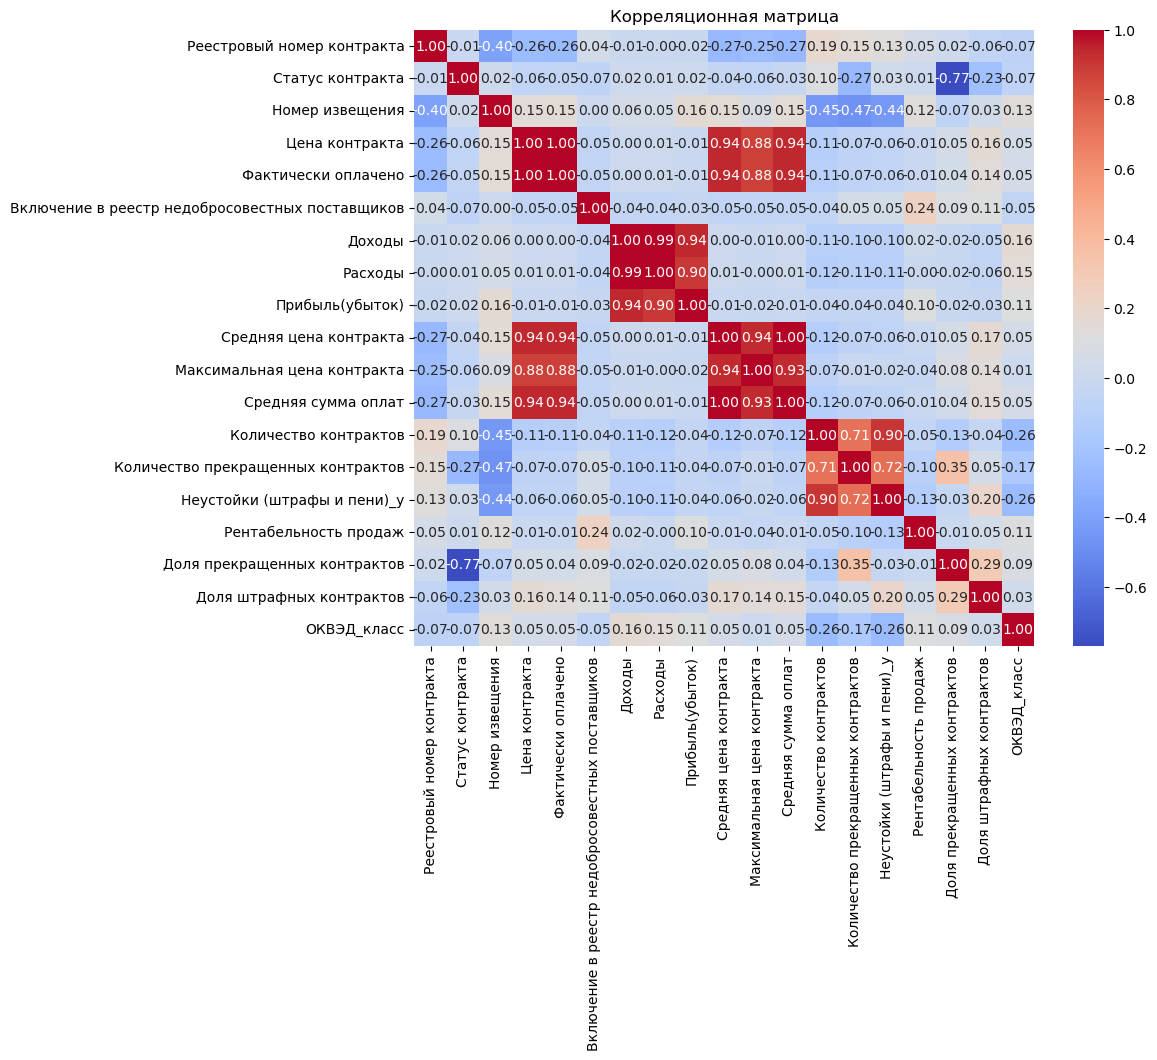

In [53]:
numeric_df = full_df.select_dtypes(include=["number"])

# Строим корреляционную матрицу (по умолчанию метод Пирсона)
corr_matrix = numeric_df.corr()

# Визуализация
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица")
plt.show()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [55]:
features = ["Доля прекращенных контрактов", "Доля штрафных контрактов", "ОКВЭД_класс", "Количество прекращенных контрактов", "Включение в реестр недобросовестных поставщиков"]

X = full_df[features].fillna(0)
y = full_df["Статус контракта"]

In [56]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Реестровый номер контракта                       1000 non-null   int64         
 1   ИНН исполнителя                                  1000 non-null   object        
 2   Наименование исполнителя                         999 non-null    object        
 3   Статус контракта                                 1000 non-null   int32         
 4   Номер извещения                                  742 non-null    float64       
 5   Дата заключения контракта                        983 non-null    datetime64[ns]
 6   Дата окончания исполнения контракта              1000 non-null   datetime64[ns]
 7   Цена контракта                                   1000 non-null   float64       
 8   Фактически оплачено                    

In [57]:
X

,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,Количество прекращенных контрактов,Включение в реестр недобросовестных поставщиков
0,0.02439,0.02439,2.0,1.0,0
1,0.02439,0.02439,2.0,1.0,0
2,0.02439,0.02439,2.0,1.0,0
3,0.02439,0.02439,2.0,1.0,0
4,0.02439,0.02439,2.0,1.0,0
...,...,...,...,...,...
995,0.00000,0.00000,10.0,0.0,0
996,0.50000,0.00000,2.0,2.0,0
997,0.00000,0.00000,5.0,0.0,0
998,0.00000,0.00000,10.0,0.0,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [59]:
y_pred_tr = model.predict(X_train)
y_prob_tr = model.predict_proba(X_train)[:, 1]

In [60]:
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.63      0.76        35
           1       0.95      1.00      0.97       265

    accuracy                           0.95       300
   macro avg       0.95      0.81      0.87       300
weighted avg       0.95      0.95      0.95       300



In [61]:
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.93      0.50      0.65        80
           1       0.94      1.00      0.97       620

    accuracy                           0.94       700
   macro avg       0.93      0.75      0.81       700
weighted avg       0.94      0.94      0.93       700



In [62]:
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

y_pred_tr = model.predict(X_train)
y_prob_tr = model.predict_proba(X_train)[:, 1]

In [63]:
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.80      0.71        35
           1       0.97      0.94      0.96       265

    accuracy                           0.92       300
   macro avg       0.80      0.87      0.83       300
weighted avg       0.93      0.92      0.93       300



In [64]:
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.62      0.81      0.71        80
           1       0.97      0.94      0.96       620

    accuracy                           0.92       700
   macro avg       0.80      0.87      0.83       700
weighted avg       0.93      0.92      0.93       700



In [65]:
y_prob_tr

array([0.88841515, 0.69229604, 0.76085054, 0.89080199, 0.88841515,
       0.38529987, 0.88841515, 0.84209194, 0.88841515, 0.69229604,
       0.00154703, 0.61866704, 0.88841515, 0.76085054, 0.16662277,
       0.61866704, 0.61866704, 0.73622555, 0.76085054, 0.61866704,
       0.61866704, 0.84209194, 0.88841515, 0.89589521, 0.88841515,
       0.88841515, 0.16327502, 0.88841515, 0.61866704, 0.8489959 ,
       0.61866704, 0.8489959 , 0.3428363 , 0.61866704, 0.89080199,
       0.86481891, 0.88598282, 0.61866704, 0.86481891, 0.88841515,
       0.88841515, 0.00556543, 0.88953425, 0.88841515, 0.88598282,
       0.16945365, 0.16662277, 0.8489959 , 0.88841515, 0.88598282,
       0.88841515, 0.88841515, 0.88841515, 0.88841515, 0.73488674,
       0.84209194, 0.86481891, 0.33495429, 0.61866704, 0.61866704,
       0.86481891, 0.89080199, 0.16662277, 0.36434811, 0.88841515,
       0.88841515, 0.84209194, 0.61866704, 0.88841515, 0.54806188,
       0.15998161, 0.79565407, 0.88841515, 0.61866704, 0.88841

In [66]:
X_train

,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,Количество прекращенных контрактов,Включение в реестр недобросовестных поставщиков
739,0.000000,0.000000,1.0,0.0,0
894,0.117647,0.000000,2.0,2.0,0
57,0.090909,0.000000,4.0,1.0,0
490,0.000000,0.000000,0.0,0.0,0
669,0.000000,0.000000,1.0,0.0,0
...,...,...,...,...,...
466,0.090909,0.045455,1.0,2.0,0
752,0.000000,0.000000,1.0,0.0,0
95,0.000000,0.000000,0.0,0.0,0
620,0.000000,0.000000,1.0,0.0,0


In [67]:
y_prob_tr

array([0.88841515, 0.69229604, 0.76085054, 0.89080199, 0.88841515,
       0.38529987, 0.88841515, 0.84209194, 0.88841515, 0.69229604,
       0.00154703, 0.61866704, 0.88841515, 0.76085054, 0.16662277,
       0.61866704, 0.61866704, 0.73622555, 0.76085054, 0.61866704,
       0.61866704, 0.84209194, 0.88841515, 0.89589521, 0.88841515,
       0.88841515, 0.16327502, 0.88841515, 0.61866704, 0.8489959 ,
       0.61866704, 0.8489959 , 0.3428363 , 0.61866704, 0.89080199,
       0.86481891, 0.88598282, 0.61866704, 0.86481891, 0.88841515,
       0.88841515, 0.00556543, 0.88953425, 0.88841515, 0.88598282,
       0.16945365, 0.16662277, 0.8489959 , 0.88841515, 0.88598282,
       0.88841515, 0.88841515, 0.88841515, 0.88841515, 0.73488674,
       0.84209194, 0.86481891, 0.33495429, 0.61866704, 0.61866704,
       0.86481891, 0.89080199, 0.16662277, 0.36434811, 0.88841515,
       0.88841515, 0.84209194, 0.61866704, 0.88841515, 0.54806188,
       0.15998161, 0.79565407, 0.88841515, 0.61866704, 0.88841

In [68]:
X_train_prop = X_train.copy()
X_train_prop["probability"] = y_prob_tr

In [69]:
X_train_prop.head()

,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,Количество прекращенных контрактов,Включение в реестр недобросовестных поставщиков,probability
739,0.000000,0.0,1.0,0.0,0,0.888415
894,0.117647,0.0,2.0,2.0,0,0.692296
57,0.090909,0.0,4.0,1.0,0,0.760851
490,0.000000,0.0,0.0,0.0,0,0.890802
669,0.000000,0.0,1.0,0.0,0,0.888415


In [70]:
X_test_prop = X_test.copy()
X_test_prop["probability"] = y_prob

In [71]:
X_test_prop.head()

,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,Количество прекращенных контрактов,Включение в реестр недобросовестных поставщиков,probability
147,0.000000,1.000000,10.0,0.0,0,0.874902
977,0.000000,0.000000,2.0,0.0,0,0.885983
976,1.000000,0.000000,2.0,2.0,0,0.004646
972,0.090909,0.045455,1.0,2.0,0,0.736226
240,0.053097,0.044248,0.0,6.0,0,0.618667


In [72]:
X_res = pd.concat([X_train_prop, X_test_prop])

In [73]:
X_res

,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,Количество прекращенных контрактов,Включение в реестр недобросовестных поставщиков,probability
739,0.000000,0.0,1.0,0.0,0,0.888415
894,0.117647,0.0,2.0,2.0,0,0.692296
57,0.090909,0.0,4.0,1.0,0,0.760851
490,0.000000,0.0,0.0,0.0,0,0.890802
669,0.000000,0.0,1.0,0.0,0,0.888415
...,...,...,...,...,...,...
481,0.000000,0.0,3.0,0.0,0,0.883504
363,0.000000,0.0,2.0,0.0,0,0.885983
125,1.000000,0.0,0.0,2.0,1,0.004507
198,0.000000,0.0,1.0,0.0,0,0.888415


In [74]:
full_df_prob = pd.concat([full_df, X_res["probability"]], axis = 1)

In [75]:
full_df_prob.head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),ОКВЭД,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,probability
0,2780515018525000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722002e+17,2025-06-09,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
1,2780514542825000014,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
2,2780514943025000017,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,329751.93,329751.93,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
3,2780514920725000015,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
4,2780514540325000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-05-31,2025-12-31,155338.94,155338.94,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
5,2780514545025000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
6,2780516644225000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Да,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
7,2780514935925000013,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,108528.16,108528.16,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
8,2780514490725000020,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722002e+17,2025-06-10,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
9,2780514541025000019,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,176544.38,176544.38,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092


In [131]:
full_df_prob.head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),ОКВЭД,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,probability
0,2780515018525000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722002e+17,2025-06-09,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
1,2780514542825000014,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
2,2780514943025000017,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,329751.93,329751.93,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
3,2780514920725000015,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
4,2780514540325000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-05-31,2025-12-31,155338.94,155338.94,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
5,2780514545025000007,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,78118.22,78118.22,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
6,2780516644225000010,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,119338.94,119338.94,NaN,NaN,Да,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
7,2780514935925000013,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,108528.16,108528.16,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
8,2780514490725000020,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722002e+17,2025-06-10,2025-12-31,88272.19,88272.19,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092
9,2780514541025000019,7839128195,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АЭФТ...",1,3.722001e+17,2025-06-02,2025-12-31,176544.38,176544.38,NaN,NaN,Нет,0,30983000.0,30753000.0,230000.0,Обеспечение работоспособности тепловых сетей,1.121014e+05,329751.93,1.120818e+05,41.0,1.0,1.0,0.007423,0.024390,0.024390,2.0,0.842092


In [144]:
group_full_df_prob = full_df_prob.groupby('ИНН исполнителя', as_index=False).agg(probability_mean=('probability', 'mean'))

In [145]:
group_full_df_prob.drop(0, axis=0, inplace=True)

In [146]:
group_full_df_prob.reset_index(drop=True, inplace=True)

In [159]:
group_full_df_prob.head()

,ИНН исполнителя,probability_mean
0,1001146420,0.005996
1,1001333318,0.004709
2,102002711630,0.864819
3,141701766795,0.004507
4,2100009963,0.883504


In [158]:
group_full_df_prob.sort_values(by = "probability_mean", ascending = False)["probability_mean"].unique()

array([0.89917303, 0.89589521, 0.89295022, 0.89080199, 0.89040684,
       0.88953425, 0.88894915, 0.88841515, 0.88841515, 0.88598282,
       0.88350442, 0.88286043, 0.88266694, 0.88097939, 0.88032333,
       0.87840715, 0.87578717, 0.87490207, 0.87311888, 0.87242577,
       0.87040176, 0.86763528, 0.86481891, 0.86120773, 0.8489959 ,
       0.84209194, 0.82829104, 0.79565407, 0.76085054, 0.73622555,
       0.73488674, 0.70402541, 0.69229604, 0.62028316, 0.61866704,
       0.61800408, 0.54806188, 0.52905741, 0.39235847, 0.38657914,
       0.38529987, 0.36434811, 0.3428363 , 0.33495429, 0.33196945,
       0.28245564, 0.17290191, 0.16945365, 0.16662277, 0.16606035,
       0.16327502, 0.15998161, 0.13554348, 0.13397764, 0.01804464,
       0.00655153, 0.00624261, 0.00599632, 0.00585318, 0.00571343,
       0.00556543, 0.00549796, 0.00544382, 0.00507688, 0.00482387,
       0.00475545, 0.00470858, 0.00464606, 0.00450691, 0.00435179,
       0.0042064 , 0.00386991, 0.00154703])

In [161]:
first_df_merge_prob = pd.merge(first_df, group_full_df_prob, on = "ИНН исполнителя", how = "left")

In [170]:
first_df_merge_prob.loc[first_df_merge_prob["Максимальная цена контракта"]>50000000].sort_values(by = ["probability_mean", "Средняя цена контракта"], ascending = False).head(50)

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,probability_mean
99,7804455145,1.691746e+08,8.458728e+07,9.242786e+07,1.691646e+08,8.458228e+07,2,2.647680e+08,2.485090e+08,16259000.0,0,0,0,0.890802
66,7801353265,7.732260e+07,7.732260e+07,7.732260e+07,7.732260e+07,7.732260e+07,1,1.784840e+08,1.692280e+08,9256000.0,0,0,0,0.890802
81,7802425152,7.087600e+07,7.087600e+07,7.087600e+07,7.087600e+07,7.087600e+07,1,8.711360e+08,8.146870e+08,56449000.0,0,0,0,0.890802
209,7813295730,1.252875e+08,6.264373e+07,9.797227e+07,1.252875e+08,6.264373e+07,2,5.012900e+07,3.956400e+07,10565000.0,0,0,0,0.890802
25,434593053826,9.195331e+07,4.597665e+07,6.660000e+07,9.195331e+07,4.597665e+07,2,NaN,NaN,0.0,0,0,0,0.890802
139,7806438762,9.690000e+07,4.845000e+07,6.930000e+07,9.690000e+07,4.845000e+07,2,4.711500e+07,3.893400e+07,8181000.0,0,0,0,0.885983
54,7707049388,9.426946e+07,9.426946e+07,9.426946e+07,9.426946e+07,9.426946e+07,1,NaN,NaN,0.0,0,1,0,0.882667
280,7838365179,5.747215e+07,5.747215e+07,5.747215e+07,5.747215e+07,5.747215e+07,1,NaN,NaN,0.0,0,0,0,0.878407
55,7715617958,7.831613e+07,7.831613e+07,7.831613e+07,7.831613e+07,7.831613e+07,1,1.354294e+09,1.270166e+09,84128000.0,0,0,0,0.873119
292,7839426699,1.588530e+08,1.588530e+08,1.588530e+08,1.588530e+08,1.588530e+08,1,2.012250e+08,1.671510e+08,34074000.0,0,0,0,0.864819


In [85]:
X_train_prop

,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс,Количество прекращенных контрактов,probability
739,0.000000,0.000000,1.0,0.0,0.888077
894,0.117647,0.000000,2.0,2.0,0.690282
57,0.090909,0.000000,4.0,1.0,0.759300
490,0.000000,0.000000,0.0,0.0,0.890537
669,0.000000,0.000000,1.0,0.0,0.888077
...,...,...,...,...,...
466,0.090909,0.045455,1.0,2.0,0.734419
752,0.000000,0.000000,1.0,0.0,0.888077
95,0.000000,0.000000,0.0,0.0,0.890537
620,0.000000,0.000000,1.0,0.0,0.888077


In [104]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [105]:
pca_features = ["Цена контракта", "Доходы", "Прибыль(убыток)", "Средняя цена контракта", "Максимальная цена контракта", "Количество контрактов", "Рентабельность продаж"]

In [106]:
s = pd.to_numeric(full_df["Рентабельность продаж"], errors="coerce")

m = s[np.isfinite(s)].mean()

full_df["Рентабельность продаж"].replace([np.nan,np.inf,-np.inf], m, inplace = True)

In [107]:
X_pca = full_df[pca_features].fillna(0)
y_pca = full_df["Статус контракта"]

In [108]:
full_df.describe()

,Реестровый номер контракта,Статус контракта,Номер извещения,Цена контракта,Фактически оплачено,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,ОКВЭД_класс
count,1.000000e+03,1000.000000,7.420000e+02,1.000000e+03,9.840000e+02,1000.000000,7.250000e+02,7.250000e+02,9.990000e+02,9.990000e+02,9.990000e+02,9.990000e+02,999.000000,999.000000,999.000000,1000.000000,999.000000,999.000000,1000.000000
mean,2.658653e+18,0.885000,3.493351e+17,2.838965e+06,2.794094e+06,0.079000,3.106474e+08,2.699410e+08,2.954165e+07,2.828724e+06,4.718918e+06,2.775953e+06,21.878879,1.386386,0.801802,0.111789,0.115115,0.045045,1.725000
std,3.381601e+17,0.319182,1.522037e+17,1.084585e+07,1.082103e+07,0.269874,1.536942e+09,1.198246e+09,3.123342e+08,1.021052e+07,1.289413e+07,1.013732e+07,35.113020,2.313343,1.589910,0.149446,0.245691,0.145491,2.630265
min,1.502705e+18,0.000000,1.451000e+17,1.207380e+03,1.207380e+03,0.000000,0.000000e+00,2.680000e+05,-2.982300e+07,4.611630e+03,4.611630e+03,4.611630e+03,1.000000,0.000000,0.000000,-1.282481,0.000000,0.000000,0.000000
25%,2.780212e+18,1.000000,2.155750e+17,1.193389e+05,1.144001e+05,0.000000,2.900300e+07,2.668500e+07,0.000000e+00,1.867897e+05,3.297519e+05,1.844714e+05,1.000000,0.000000,0.000000,0.027556,0.000000,0.000000,0.000000
50%,2.780644e+18,1.000000,3.722001e+17,3.901606e+05,3.744500e+05,0.000000,5.138800e+07,4.841100e+07,2.318000e+06,5.751067e+05,1.856058e+06,5.554017e+05,4.000000,0.000000,0.000000,0.092282,0.000000,0.000000,1.000000
75%,2.781703e+18,1.000000,3.722002e+17,1.186850e+06,1.084434e+06,0.000000,1.259190e+08,1.142080e+08,6.627000e+06,1.311432e+06,3.501801e+06,1.201223e+06,22.000000,1.000000,1.000000,0.111789,0.076923,0.034483,2.000000
max,3.781703e+18,1.000000,8.725000e+17,1.588530e+08,1.588530e+08,1.000000,1.965510e+10,1.507835e+10,4.576749e+09,1.588530e+08,1.588530e+08,1.588530e+08,113.000000,12.000000,5.000000,0.917967,1.000000,1.000000,10.000000


In [109]:
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

In [110]:
pca = PCA()
X_pca = pca.fit_transform(X_pca_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Необходимо {n_components} компонент")

Для сохранения 95% дисперсии необходимо 4 компонент


In [115]:
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(X_pca_scaled)

print(f"Исходная размерность: {X_pca.shape[1]}")
print(f"Новая размерность: {X_reduced.shape[1]}")

Исходная размерность данных: 7
Новая размерность данных: 4


In [118]:
X_with_pca = pd.concat([X, pd.DataFrame(X_reduced)], axis = 1)

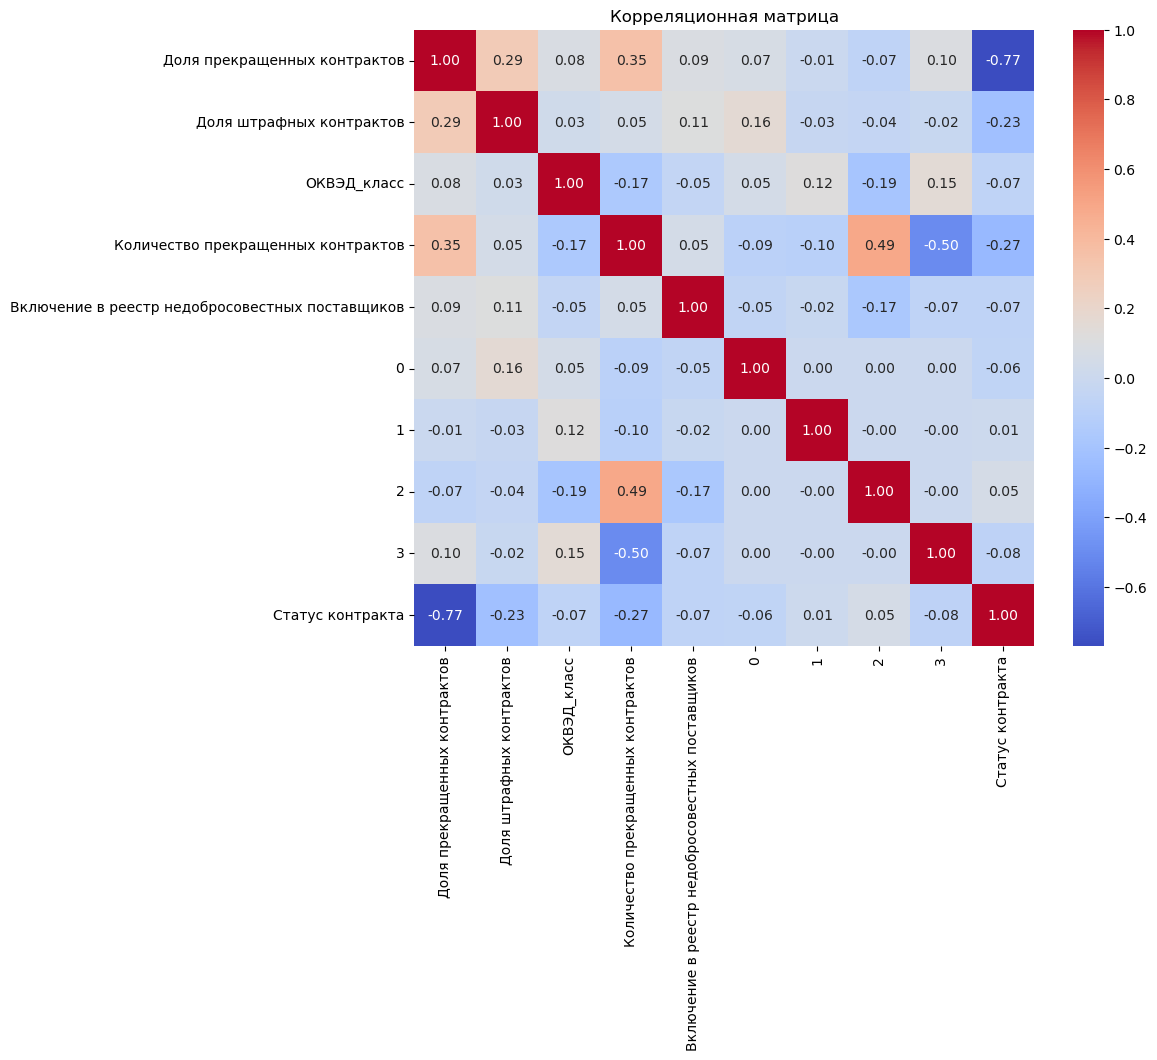

In [120]:
numeric_df_2 =  pd.concat([X_with_pca, y], axis = 1)

corr_matrix_2 = numeric_df_2.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_2, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица")
plt.show()